# Rooftop Segmentation - Roelof Kuipers

In this notebook we will perform rooftop segmentation by training a model on 25 training samples (consisting of 25 images and 25 masks). Finally we will try to locate the rooftops in 5 unseen images using the trained model.

We will perform data augmentation to increase the number of training images and create our model with the u-net architecture from [zhixuhao](https://github.com/zhixuhao/unet) using Keras. 

We will use the following approach:
* Explore the data
* Preprocess the data (define the data generator)
* Create and train the model 
* Perform rooftop segmentation on the 5 unseen images using the model
* Conclude and discuss possible imporvements.


In [0]:
import matplotlib.pyplot as plt
import numpy as np 
import os
from keras.models import *
from keras.layers import *
from keras.optimizers import *
from keras.callbacks import ModelCheckpoint, LearningRateScheduler
from keras import backend as keras
from keras.preprocessing.image import ImageDataGenerator
import skimage.io as io

## Setup environment

I have placed the training images and labels (masks) in a training folder and the 5 test images in a test folder. 

In [2]:
# from google.colab import drive
# drive.mount('/content/gdrive', force_remount=True)
# main_path='/content/gdrive/My Drive/dida-roelof-kuipers/'
# os.chdir(main_path)

Mounted at /content/gdrive


In [1]:
!ls

README.md
rooftop-segmentation-roelof-kuipers.ipynb
test
train


## Explore the data

Look at one training image and mask. 


Training images:  ['328.png', '317.png', '417.png', '303.png', '300.png', '314.png', '274.png', '315.png', '301.png', '320.png', '270.png', '272.png', '121.png', '308.png', '324.png', '532.png', '337.png', '241.png', '278.png', '284.png', '287.png', '381.png', '345.png', '379.png', '343.png']
Inspect 1 train image
Max value:  1.0
Image shape:  (256, 256, 4)


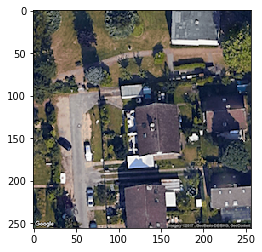

In [14]:
print('Training images: ', os.listdir("train/images"))
print('Inspect 1 train image')
img = plt.imread(os.path.join("train/images/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
imgplot = plt.imshow(img)

Inspect 1 train mask
Max value:  1.0
Image shape:  (256, 256)
Pixels in (256,256) img with value 1 : 9200
Pixels in (256,256) img with value 0 : 52917
Pixels in (256,256) img with value between 0 and 1 : 3419


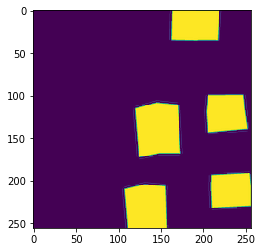

In [7]:
print('Inspect 1 train mask')
img = plt.imread(os.path.join("train/labels/121.png"))
print('Max value: ', np.amax(img))
print('Image shape: ', img.shape)
print('Pixels in (256,256) img with value 1 :',np.sum(img==1.0))
print('Pixels in (256,256) img with value 0 :',np.sum(img==0.0))
print('Pixels in (256,256) img with value between 0 and 1 :',np.sum(img>0.0)-np.sum(img==1.0))
imgplot = plt.imshow(img)

As we see, the mask has values 0, 1 and values between 0 and 1. These last values are in pixels that contain the border of the shape of the roof. 

# Define the data generator

As we only have 25 training images, we will use ImageDataGenerator for data augmentation. 

Based on a couple of runs I have selected the (basic) augmentation settings and batch_size=2 below. 

We set seed=1 to make sure that the augmented images correspond to the right augmented masks.


In [4]:
# define the types of augmentations
aug_dict = dict(rotation_range=0.2,
                width_shift_range=0.05,
                height_shift_range=0.05,
                shear_range=0.05,
                zoom_range=0.05,
                horizontal_flip=True,
                fill_mode='nearest')

# define the right folders and 
batch_size=2 
train_path='train'
image_folder='images'
mask_folder='labels'
image_color_mode='rgba'
mask_color_mode='grayscale'
target_size=(256,256)
seed=1 


# define the data generators
image_datagen = ImageDataGenerator(**aug_dict)
mask_datagen = ImageDataGenerator(**aug_dict)


image_generator = image_datagen.flow_from_directory(
    train_path,
    classes = [image_folder],
    class_mode = None,
    color_mode = image_color_mode,
    target_size = target_size,
    batch_size = batch_size,
    seed = seed)
mask_generator = mask_datagen.flow_from_directory(
    train_path,
    classes = [mask_folder],
    class_mode = None,
    color_mode = mask_color_mode,
    target_size = target_size,
    batch_size = batch_size,
    seed = seed)
train_generator = zip(image_generator, mask_generator)


# With our Generator function we can keep on calling augmented images.
# This will be used when training the model.
# we transform the pixels in the mask on the border of the roofs in the mask
# to either 0 or 1. And if needed (just to be sure) resize the images.
def Generator(train_generator):
  for (img,mask) in train_generator:
      if(np.max(img) > 1):
        img = img / 255.
        mask = mask /255.
      mask[mask > 0.5] = 1
      mask[mask <= 0.5] = 0
      yield (img,mask)
      
myGene = Generator(train_generator)

Found 25 images belonging to 1 classes.
Found 25 images belonging to 1 classes.


### Visualize the data generator

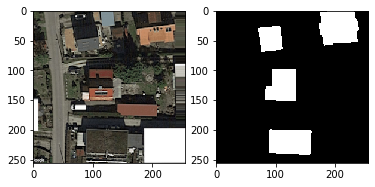

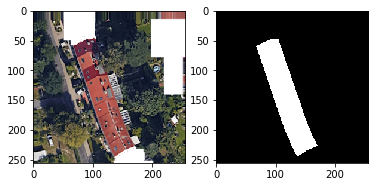

In [17]:
# check if images images are zipped
for b in range(1):
    example = next(myGene)
    for i in range(batch_size):
      img=example[0][i]
      mask=example[1][i]
      fig, ax = plt.subplots(1, 2)
      ax[0].imshow(img.squeeze(), cmap=plt.get_cmap('bone'))
      ax[1].imshow(mask.squeeze(), cmap=plt.get_cmap('bone'))
      fig.show()

In [18]:
mask=example[1][0]
print('Verify only 1 and 0 in mask:\n')
print('pix in mask with value 1 :',np.sum(mask==1.0))
print('pix in mask with value 0 :',np.sum(mask==0.0))
print('pix in mask with value no 0 or 1 :',np.sum(mask>0.0)-np.sum(mask==1.0))

Verify only 1 and 0 in mask:
pix in mask with value 1 : 10098
pix in mask with value 0 : 55438
pix in mask with value no 0 or 1 : 0


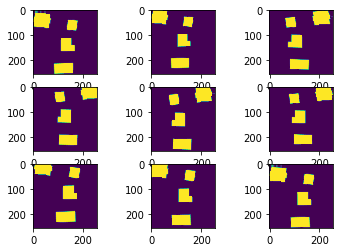

In [19]:
# see some augmentations of one mask
i=0
for i in range(9):
	plt.subplot(330 + 1 + i)
	batch = mask_generator[0][0]
	plt.imshow(batch.squeeze())
plt.show()

# Define & train the model

We use the u-net architecture from [zhixuhao](https://github.com/zhixuhao/unet) and train our model for 10 epochs with 300 steps per epoch (of batch_size 2). This setup was chosen after running the model for a couple of different epochs, steps_per_epoch and batch_sizes. 

In [7]:
epochs=10
steps_per_epoch=300

from model import *
model = unet(input_size = (256,256,4))
model.fit_generator(myGene,steps_per_epoch=steps_per_epoch,epochs=epochs)


/content/gdrive/My Drive/dida-roelof-kuipers/model.py:50: UserWarning: Update your `Model` call to the Keras 2 API: `Model(inputs=Tensor("in..., outputs=Tensor("co...)`
  model = Model(input = inputs, output = conv10)


Epoch 1/10
300/300 [==============================] - 140s 466ms/step - loss: 0.3494 - acc: 0.8574
Epoch 2/10
300/300 [==============================] - 132s 438ms/step - loss: 0.2447 - acc: 0.9139
Epoch 3/10
300/300 [==============================] - 131s 437ms/step - loss: 0.2140 - acc: 0.9258
Epoch 4/10
300/300 [==============================] - 131s 437ms/step - loss: 0.1925 - acc: 0.9392
Epoch 5/10
300/300 [==============================] - 131s 436ms/step - loss: 0.1331 - acc: 0.9516
Epoch 6/10
300/300 [==============================] - 131s 436ms/step - loss: 0.0927 - acc: 0.9646
Epoch 7/10
300/300 [==============================] - 131s 436ms/step - loss: 0.0738 - acc: 0.9713
Epoch 8/10
300/300 [==============================] - 131s 437ms/step - loss: 0.0551 - acc: 0.9780
Epoch 9/10
300/300 [==============================] - 132s 439ms/step - loss: 0.0355 - acc: 0.9856
Epoch 10/10
300/300 [==============================] - 131s 438ms/step - loss: 0.0327 - acc: 0.9870


I have also used a small subset of 4 of the 25 rooftop trianing images as a validation set and trained the model with data augmentation. This, as I wanted to be sure that my model was not overfitting. I am happy to previde the results of that run if necessary.

## Test the model

We will finally test the model and try to find the roofs on 5 test images.


In [8]:
test_datagen = ImageDataGenerator(rescale=1./255)
test_path='test'
image_folder='images'

test_generator = test_datagen.flow_from_directory(
        test_path,
        classes = [image_folder],
        class_mode = None,
        color_mode = image_color_mode,
        target_size = target_size,
        batch_size = 1)
 
filenames = [x[-7:] for x in test_generator.filenames]
test_samples = len(filenames)

results = model.predict_generator(test_generator,steps = test_samples, verbose=1)

Found 5 images belonging to 1 classes.
5/5 [==============================] - 1s 163ms/step


In [0]:
def saveResult(save_path,results,filenames):
    for i,item in enumerate(results):
        img = item[:,:,0]
        img_name = filenames[i]
        io.imsave(os.path.join(save_path, img_name),img)
        
saveResult("test/labels/",(results*255).astype(np.uint8), filenames)

## Conclusion

The results of the rooftop segmentation are quite good. After visually comparing the test masks/labels to the images we see that they are quite accurate.

Some possible improvements for the future would be: checking if we could get better results by altering the u-net model, using transfer learning with a model with pre-trained weights for rooftop segmentation. 
